## Dataset: Swedish texts published during 2021 about *COVID-19*

### **Sentiment analysis**: a branch of artificial intelligence and natural language processing that evaluates the emotional tone of textual data. It categorizes text as (very) positive, (very) negative, or neutral, providing insights into public opinion.

**Import Primary Libraries/Packages**

In [90]:
import pandas as pd
from collections import defaultdict
import re
from io import StringIO
import requests
import matplotlib.pyplot as plt
import numpy as np

**The various processing steps**


In [91]:
# Step 1: Load CSV file from URL
def load_csv_from_url(url):
    s = requests.get(url).text
    df = pd.read_csv(StringIO(s), sep="\t")
    print('\nThe Swedish .csv file is loaded!')
    return df

# Step 2: Load sentiment lexicon into memory
def load_sentiment_lexicon(lexicon_file_path):
    lexicon = {}
    with open(lexicon_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            token, polarity, strength, confidence = line.strip().split(',')
            lexicon[token] = {
                'polarity': polarity,
                'strength': float(strength),
                'confidence': float(confidence)
            }
    print('\nThe Swedish sentiment words are loaded!')
    return lexicon

# Step 3: Tokenize text and annotate it with sentiment information
def annotate_text(text, lexicon):
    #tokens = re.findall(r'\b\w+\b', text.lower())
    tokens = re.findall(r'\b\w+(?:[-_]\w+)*\b', text.lower())
    annotated_tokens = []
    annotations = {'all': 0, 'pos': 0, 'neg': 0, 'very_pos': 0, 'very_neg': 0}

    for token in tokens:
        if token in lexicon:
            sentiment = lexicon[token]
            annotated_token = f"{token}[{sentiment['polarity']}, {sentiment['strength']}, {sentiment['confidence']}]"
            annotated_tokens.append(annotated_token)

            # Increment the annotation counts
            annotations['all'] += 1
            if sentiment['polarity'] == 'pos':
                annotations['pos'] += 1
            elif sentiment['polarity'] == 'neg':
                annotations['neg'] += 1
            elif sentiment['polarity'] == 'very-pos':
                annotations['very_pos'] += 1
            elif sentiment['polarity'] == 'very-neg':
                annotations['very_neg'] += 1
        else:
            annotated_tokens.append(token)  # Keep the token as-is if no annotation

    return ' '.join(annotated_tokens), annotations

# Step 4: Process the data and calculate monthly/annual statistics
def process_data(df, lexicon):
    monthly_stats = defaultdict(lambda: {'all': 0, 'pos': 0, 'neg': 0, 'very_pos': 0, 'very_neg': 0})
    annual_stats = {'all': 0, 'pos': 0, 'neg': 0, 'very_pos': 0, 'very_neg': 0}

    for idx, row in df.iterrows():
        date = row['date']
        text = row['text']

        # Annotate the text
        annotated_text, annotations = annotate_text(text, lexicon)
        df.at[idx, 'annotated_text'] = annotated_text

        month = date.strftime('%Y-%m')

        # Update monthly and annual stats
        for key in annotations:
            monthly_stats[month][key] += annotations[key]
            annual_stats[key] += annotations[key]

    return df, monthly_stats, annual_stats

In [92]:
# Step 5: Display statistics
from IPython.display import display
def display_stats(monthly_stats, annual_stats):
    # Convert monthly_stats to DataFrame for better visualization
    monthly_df = pd.DataFrame(monthly_stats).T.fillna(0)
    monthly_df = monthly_df.astype(int)  # Convert to integer for better display

    # Create a colormap using viridis
    cmap = plt.get_cmap('viridis')

    # Normalize the values for color mapping
    # Add a small value to avoid division by zero
    color_mapping = monthly_df.values / (monthly_df.values.max() + 1e-10)

    # Apply colors to the DataFrame based on the viridis colormap
    def colorize(val):
        color_idx = int(val * (cmap.N - 1))  # Map to the colormap range
        return f'background-color: {cmap(color_idx) if color_idx < cmap.N else "white"}'

    colored_monthly_df = monthly_df.style.applymap(colorize)

    # Display the monthly statistics table
    display(colored_monthly_df.set_caption("<br>Monthly Sentiment Statistics"))

    # Convert annual_stats to DataFrame
    annual_df = pd.DataFrame(annual_stats, index=[0])
    annual_df = annual_df.astype(int)  # Convert to integer for better display

    # Create a simple styling for the annual statistics
    colored_annual_df = annual_df.style.apply(lambda x: ['background-color: #f0f0f0' if v > 0 else '' for v in x], axis=1)

    # Display the annual statistics table
    display(colored_annual_df.set_caption("Annual Sentiment Statistics"))

**Loading the CSV and the Swedish sentiment lexicon**

In [93]:
csv_url = "https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/textual-resources/sv_CovidCorpus2.csv"
lexicon_url = "https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/lexical-resources/sv_sentiment_lexicon.txt"

# Load CSV
s = requests.get(csv_url).text
df = pd.read_csv(StringIO(s), sep="\t")

# Use curl to download the lexicon file
!curl -L {lexicon_url} --output sentiment_lexicon.txt

# Load lexicon into memory
sentiment_lexicon = load_sentiment_lexicon('sentiment_lexicon.txt')

# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Process data and compute statistics
df, monthly_stats, annual_stats = process_data(df, sentiment_lexicon)

# Display statistics
display_stats(monthly_stats, annual_stats)

# Optionally save the annotated dataframe to a new CSV
df.to_csv('annotated_texts.csv', index=False)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56580  100 56580    0     0   299k      0 --:--:-- --:--:-- --:--:--  298k

The Swedish sentiment words are loaded!


<ipython-input-92-c8801d7288a7>:20: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,all,pos,neg,very_pos,very_neg
2021-01,2932,1127,1606,125,74
2021-02,2985,1106,1628,128,123
2021-03,3117,1162,1693,158,104
2021-04,2939,1132,1579,136,92
2021-05,3224,1152,1807,157,108
2021-06,2171,898,1112,112,49
2021-07,1188,427,675,50,36
2021-08,1657,640,888,89,40
2021-09,2194,835,1181,131,47
2021-10,1763,683,956,73,51


,all,pos,neg,very_pos,very_neg
0,28225,10671,15369,1380,805


In [94]:
#add 20 most freq, list with all 'pos', 'neg' etc. found in the  data

In [95]:
import plotly.graph_objects as go

# Adjusted function for Monthly Sentiment Polarity Stats with green color variants
def plot_monthly_polarity_stats(monthly_stats):
    months = sorted(monthly_stats.keys())
    very_pos = [monthly_stats[m]['very_pos'] for m in months]
    pos = [monthly_stats[m]['pos'] for m in months]
    neg = [monthly_stats[m]['neg'] for m in months]
    very_neg = [monthly_stats[m]['very_neg'] for m in months]

    # Define green color variants
    very_pos_color = '#228B22'  # Forest Green
    pos_color = '#66CDAA'       # Medium Aquamarine
    #neg_color = '#fdae6b'       # Light Orange
    #very_neg_color = '#e6550d'  # Bright Orange
    very_neg_color = '#8B0000'       # Dark Red
    neg_color = '#DC143C'  # Crimson

    fig = go.Figure()

    # Adding traces with green color variants
    fig.add_trace(go.Bar(
        x=months,
        y=very_pos,
        name='Very Positive',
        marker=dict(color=very_pos_color),
        text=very_pos,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        x=months,
        y=pos,
        name='Positive',
        marker=dict(color=pos_color),
        text=pos,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        x=months,
        y=neg,
        name='Negative',
        marker=dict(color=neg_color),
        text=neg,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        x=months,
        y=very_neg,
        name='Very Negative',
        marker=dict(color=very_neg_color),
        text=very_neg,
        textposition='auto'
    ))

    fig.update_layout(
        title={'text': 'Monthly Sentiment Polarity Distribution', 'font': {'size': 20, 'family': 'Arial Black', 'color': 'black'}, 'x':0.5},
        xaxis_title='<b>Month (2021)</b>',
        yaxis_title='<b>Number of Polarity Occurrences</b>',
        barmode='stack',
        legend=dict(title='Sentiment'),
        template='ggplot2'
    )

    fig.show()

# Adjusted function for Genre-Based Sentiment Polarity Stats with green color variants
def plot_genre_polarity_stats(df):
    genres = df['genre'].unique()
    genre_stats = {genre: {'very_pos': 0, 'pos': 0, 'neg': 0, 'very_neg': 0} for genre in genres}

    for idx, row in df.iterrows():
        genre = row['genre']
        annotated_text, annotations = annotate_text(row['text'], sentiment_lexicon)
        for key in genre_stats[genre]:
            genre_stats[genre][key] += annotations[key]

    genres_sorted = sorted(genres)
    very_pos = [genre_stats[g]['very_pos'] for g in genres_sorted]
    pos = [genre_stats[g]['pos'] for g in genres_sorted]
    neg = [genre_stats[g]['neg'] for g in genres_sorted]
    very_neg = [genre_stats[g]['very_neg'] for g in genres_sorted]

    fig = go.Figure()

    # Adding traces with green color variants
    fig.add_trace(go.Bar(
        y=genres_sorted,
        x=very_pos,
        name='Very Positive',
        marker=dict(color=very_pos_color),
        orientation='h',
        text=very_pos,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        y=genres_sorted,
        x=pos,
        name='Positive',
        marker=dict(color=pos_color),
        orientation='h',
        text=pos,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        y=genres_sorted,
        x=neg,
        name='Negative',
        marker=dict(color=neg_color),
        orientation='h',
        text=neg,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        y=genres_sorted,
        x=very_neg,
        name='Very Negative',
        marker=dict(color=very_neg_color),
        orientation='h',
        text=very_neg,
        textposition='auto'
    ))

    fig.update_layout(
        title={'text': 'Genre-Based Sentiment Polarity Distribution', 'font': {'size': 20, 'family': 'Arial Black', 'color': 'black'}, 'x':0.5},
        xaxis_title='<b>Number of Polarity Occurrences</b>',
        yaxis_title='<b>Genre</b>',
        barmode='stack',
        legend=dict(title='Sentiment'),
        template='ggplot2'
    )

    fig.show()

In [96]:
# Define green color variants here, making them globally accessible
very_pos_color = '#228B22'  # Forest Green
pos_color = '#66CDAA'       # Medium Aquamarine
very_neg_color = '#8B0000'       # Dark Red
neg_color = '#DC143C'  # Crimson

# Example Usage
plot_monthly_polarity_stats(monthly_stats)
plot_genre_polarity_stats(df)

In [97]:
!pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Random Sentence Selection with Token Highlighting**


In [98]:
import re
from IPython.display import display, HTML

# Function to select random sentences and show both original and highlighted versions
def select_random_sentences_with_original(df, sentiment_lexicon):
    # Filter sentences with length between 5 and 20 tokens
    filtered_sentences = df[df['text'].apply(lambda x: 5 <= len(re.findall(r'\b\w+\b', x)) <= 25)]

    # Check how many sentences are available after filtering
    num_sentences = len(filtered_sentences)

    # If there are fewer than 20 sentences, adjust sample size
    sample_size = min(num_sentences, 20)

    # Select random rows from the filtered DataFrame
    random_sentences = filtered_sentences.sample(sample_size)

    # Iterate through selected random sentences
    for idx, row in random_sentences.iterrows():
        original_sentence = row['text']  # The original sentence (unprocessed)
        #tokens = re.findall(r'\b\w+\b', original_sentence.lower())
        tokens = re.findall(r'\b\w+(?:[-_]\w+)*\b', original_sentence.lower())
        highlighted_sentence = []

        # Annotate tokens based on sentiment
        for token in tokens:
            if token in sentiment_lexicon:
                sentiment = sentiment_lexicon[token]['polarity']
                # Color the token based on sentiment and make it bold with larger font
                if sentiment == 'very-pos':
                    highlighted_token = f'<span style="color:darkgreen; font-weight:bold; font-size: 1.5em;">{token}</span>'
                elif sentiment == 'pos':
                    highlighted_token = f'<span style="color:lightgreen; font-weight:bold; font-size: 1.5em;">{token}</span>'
                elif sentiment == 'neg':
                    highlighted_token = f'<span style="color:lightcoral; font-weight:bold; font-size: 1.5em;">{token}</span>'
                elif sentiment == 'very-neg':
                    highlighted_token = f'<span style="color:darkred; font-weight:bold; font-size: 1.5em;">{token}</span>'
            else:
                highlighted_token = token  # No annotation for words not found in the lexicon
            highlighted_sentence.append(highlighted_token)

        # Join the processed tokens to form the highlighted sentence
        processed_sentence = ' '.join(highlighted_sentence)

        # Display both original and highlighted sentences in HTML
        display(HTML(f"<p><strong>Original Sentence:</strong> {original_sentence}</p>"))  # Output original sentence
        display(HTML(f"<p><strong>Highlighted Sentence:</strong> {processed_sentence}</p>"))  # Output processed sentence
        print("-" * 80)  # Separator for clarity between different sentences

# Example Usage
select_random_sentences_with_original(df, sentiment_lexicon)

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


--------------------------------------------------------------------------------


In [99]:
#todo
#increase the lexicon
#ratio pos/neg per month (and year)

In [100]:
import pandas as pd
import requests
from io import StringIO
import random
from collections import defaultdict

# Step 1: Load the CSV file
url = "https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/textual-resources/sv_CovidCorpus2.csv"
response = requests.get(url).text
df = pd.read_csv(StringIO(response), sep="\t")

# Step 2: Load the sentiment lexicon
def load_sentiment_lexicon(file_path):
    lexicon = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            token, sentiment, polarity, strength = line.strip().split(',')
            lexicon[token] = (sentiment, polarity, float(strength))
    return lexicon

# Fetch the sentiment lexicon
lexicon_url = "https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/lexical-resources/sv_sentiment_lexicon.txt"
!curl -L $lexicon_url --output sentiment_lexicon.txt
sentiment_lexicon = load_sentiment_lexicon('sentiment_lexicon.txt')
print('Swedish sentiment lexicon loaded successfully!')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56580  100 56580    0     0   244k      0 --:--:-- --:--:-- --:--:--  245k
Swedish sentiment lexicon loaded successfully!


In [101]:
# Step 3: Annotate the text
def annotate_text(text, lexicon):
    tokens = text.split()  # Simple tokenization
    annotated_tokens = []
    very_pos_count = very_neg_count = pos_count = neg_count = neutral_count = 0

    for token in tokens:
        if token in lexicon:
            sentiment, polarity, strength = lexicon[token]
            annotated_tokens.append(f"{token}[{sentiment},{polarity},{strength}]")
            if sentiment == 'pos':
                pos_count += 1
            elif sentiment == 'neg':
                neg_count += 1
            elif sentiment == 'very-neg':
                very_neg_count += 1
            elif sentiment == 'very-pos':
                very_pos_count += 1
        else:
            annotated_tokens.append(token)
            neutral_count += 1

    # Return all 6 values: annotated text and counts for each sentiment
    return ' '.join(annotated_tokens), pos_count, neg_count, very_pos_count, very_neg_count, neutral_count

# Apply annotation for the entire DataFrame
df['annotated_text'], df['pos_count'], df['neg_count'], df['very_pos_count'], df['very_neg_count'], df['neutral_count'] = zip(*df['text'].apply(lambda x: annotate_text(x, sentiment_lexicon)))


In [102]:
import pandas as pd
import numpy as np

# Step 4: Calculate pos/neg ratio per month
df['date'] = pd.to_datetime(df['date'])  # Ensure the date column is in datetime format
df['year_month'] = df['date'].dt.to_period('M')

# Group by year and month and calculate pos/neg ratio
sentiment_summary = df.groupby('year_month').agg({
    'pos_count': 'sum',
    'neg_count': 'sum',
    'very_pos_count': 'sum',
    'very_neg_count': 'sum'
})

# Combine counts
sentiment_summary['total_pos_count'] = sentiment_summary['pos_count'] + sentiment_summary['very_pos_count']
sentiment_summary['total_neg_count'] = sentiment_summary['neg_count'] + sentiment_summary['very_neg_count']

# Calculate pos/neg ratio
def calculate_pos_neg_ratio(row):
    pos = row['total_pos_count']
    neg = row['total_neg_count']

    # Handle cases where both are zero to avoid division by zero
    if pos == 0 and neg == 0:
        return np.nan
    elif pos == 0:
        return f"-{neg}"  # If no positives, return negative count
    elif neg == 0:
        return str(pos)  # If no negatives, return positive count
    elif pos > neg:
        return f"{pos / neg:.2f}"  # Positive ratio
    else:
        return f"-{neg / pos:.2f}"  # Negative ratio

# Apply the function to calculate the ratio for each row
sentiment_summary['pos_neg_ratio'] = sentiment_summary.apply(calculate_pos_neg_ratio, axis=1)

# Output the sentiment summary with the ratio
print(sentiment_summary)


            pos_count  neg_count  very_pos_count  very_neg_count  \
year_month                                                         
2021-01          1033       1261             119              63   
2021-02          1017       1237             118             110   
2021-03          1030       1317             145              91   
2021-04          1019       1248             120              69   
2021-05          1022       1379             135              89   
2021-06           812        846             101              44   
2021-07           386        495              45              33   
2021-08           565        722              82              27   
2021-09           764        939             116              41   
2021-10           622        733              67              39   
2021-11           644        822              96              33   
2021-12           731        966             114              36   

            total_pos_count  total_neg_count po

In [103]:
# Function to color the sentiment tokens
def color_sentiment(tokens, lexicon):
    colored_text = []

    for token in tokens:
        # Check if the token is in the sentiment lexicon
        if token in lexicon:
            sentiment, polarity, strength = lexicon[token]
            if sentiment == 'pos':
                colored_text.append(f"\033[92m{token}\033[0m")  # Green for positive
            elif sentiment == 'very-pos':
                colored_text.append(f"\033[1;92m{token}\033[0m")  # Bright green for very positive
            elif sentiment == 'neg':
                colored_text.append(f"\033[91m{token}\033[0m")  # Red for negative
            elif sentiment == 'very-neg':
                colored_text.append(f"\033[1;91m{token}\033[0m")  # Bright red for very negative
            else:
                colored_text.append(token)  # No color for neutral or unknown sentiment
        else:
            colored_text.append(token)  # If token not in lexicon, add without color

    return ' '.join(colored_text)

In [104]:
# Select random sentences between 5 and 25 tokens
valid_sentences = df[df['text'].apply(lambda x: 5 <= len(x.split()) <= 25)]

# Check the number of valid sentences
num_valid_sentences = len(valid_sentences)

# Sample a maximum of num_valid_sentences
sampled_sentences = valid_sentences['text'].sample(min(num_valid_sentences, 20)).tolist()

# Color the sampled sentences
for sentence in sampled_sentences:
    # Tokenize the sentence into words (tokens)
    tokens = sentence.split()

    # Call the color_sentiment function with tokenized words and print the colored sentence
    print(color_sentiment(tokens, sentiment_lexicon))

Ett år har gått sedan det första coronafallet bekräftades i Sverige. Här är en del ögonblick från året som gått.
Astra_Zenecas vaccin mot covid_19 bör stoppas även för äldre, det säger Marco Cavaleri, vaccinchef på Europeiska läkemedelsmyndigheten (EMA). Källor: URL
Magnus Gisslén Minnes- och koncentrationssvårigheter är vanliga flera månader efter en svår covid-19-infektion. Det visar en ny stor amerikansk studie som har följt_upp patienter.
En dödlig pandemi och ett vaccin som inte genast räcker till alla, utan där vissa grupper måste prioriteras.
Tiotusentals marscherade återigen genom Amsterdam för att protestera mot den nederländska regeringens coronaviruspass i helgen.
URL PCR-bedrägeriet är fastställt i domstol inom EU och myndighetschef & riksåklagaren Petra Lundh är väl känd med dessa fastställande domar.
Över stora delar av Europa drar en ny kraftig coronavåg fram. Vi står mitt i en pandemiexplosion , säger Polens hälsominister Adam Niedzielski.
Sex månader efter den andra_do

In [105]:
valid_sentences

,id,date,genre,text,annotated_text,pos_count,neg_count,very_pos_count,very_neg_count,neutral_count,year_month
261,262,2021-01-31,NEWS,En dödlig pandemi och ett vaccin som inte gena...,"En dödlig[neg,-2,0.5] pandemi[neg,-2,0.5] och ...",0,3,0,0,15,2021-01
265,266,2021-01-31,PBLMD,Ett år har gått sedan det första coronafallet ...,Ett år har gått sedan det första coronafallet ...,0,0,0,0,20,2021-01
379,380,2021-02-10,NEWS,Covid-19-vaccinering. Arkivbild. Ytterligare d...,Covid-19-vaccinering. Arkivbild. Ytterligare d...,0,3,0,0,17,2021-02
1247,1248,2021-05-12,NEWS,En ovanlig svamp har upptäckts i hjärnan hos c...,En ovanlig svamp har upptäckts i hjärnan hos c...,0,2,0,1,17,2021-05
1542,1543,2021-06-13,PRDCL,Astra_Zenecas vaccin mot covid_19 bör stoppas ...,"Astra_Zenecas vaccin mot covid_19[neg,-2,0.5] ...",0,1,0,0,19,2021-06
1587,1588,2021-06-19,NEWS,Oro för dödliga följdeffekten av corona Svampi...,"Oro för dödliga[neg,-2,0.5] följdeffekten av c...",0,1,0,0,10,2021-06
2159,2160,2021-09-28,PBLMD,Sex månader efter den andra_dosen av Pfizer_va...,Sex månader efter den andra_dosen av Pfizer_va...,0,0,0,0,12,2021-09
2213,2214,2021-10-06,NEWS,Tiotusentals marscherade återigen genom Amster...,Tiotusentals marscherade återigen genom Amster...,0,0,0,0,15,2021-10
2269,2270,2021-10-20,NEWS,Över stora delar av Europa drar en ny kraftig ...,"Över stora delar av Europa drar en ny[pos,2,0....",2,1,0,0,20,2021-10
2279,2280,2021-10-22,NEWS,Magnus Gisslén Minnes- och koncentrationssvåri...,Magnus Gisslén Minnes- och koncentrationssvåri...,2,0,0,1,21,2021-10


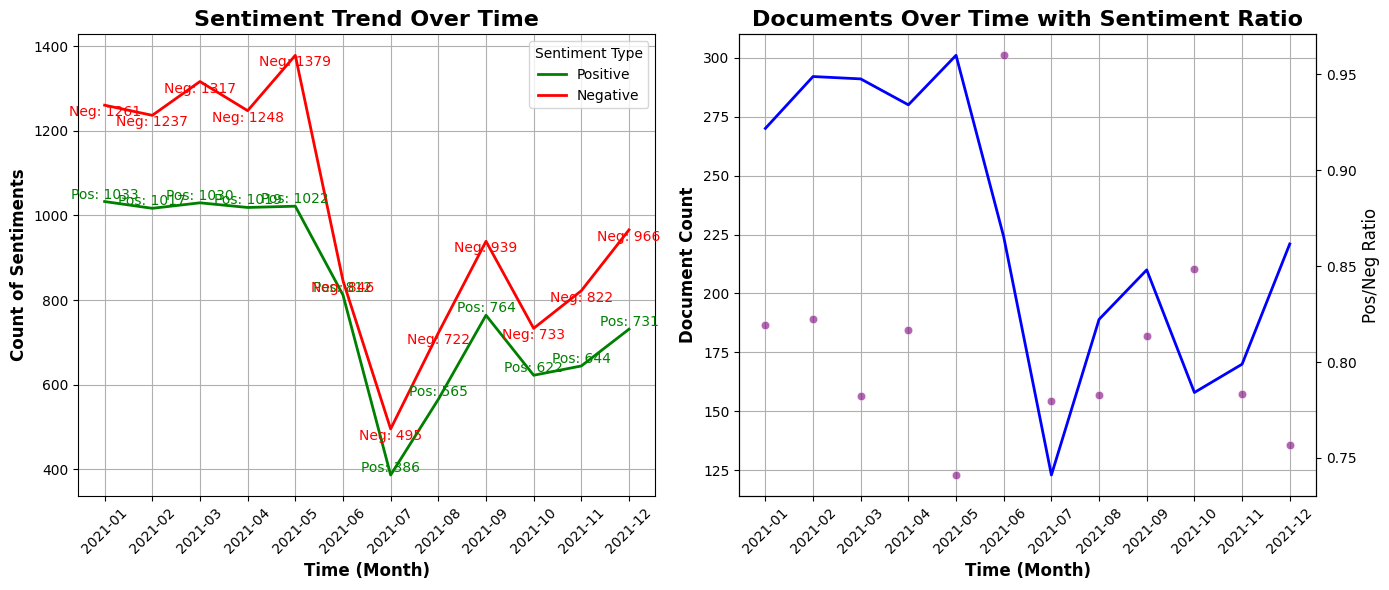

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the data
# We already have sentiment_summary that contains pos_count, neg_count, and pos_neg_ratio by year_month
df['doc_count'] = 1  # Add a column to represent each document as count 1
document_counts = df.groupby('year_month')['doc_count'].count()  # Count of documents per month

# Merge document counts with sentiment summary
sentiment_summary['doc_count'] = document_counts

# Step 2: Compute the pos_neg_ratio
sentiment_summary['pos_neg_ratio'] = (
    sentiment_summary['pos_count'] / sentiment_summary['neg_count']
).replace([float('inf'), -float('inf')], 0)  # Handle division by zero or infinity cases

# Negate the ratio if negative
sentiment_summary['pos_neg_ratio'] = sentiment_summary['pos_neg_ratio'].where(sentiment_summary['neg_count'] > 0, -sentiment_summary['pos_neg_ratio'])

# Step 3: First plot - Sentiment Trend Line Plot (Pos/Neg over time)
plt.figure(figsize=(14, 6))

# Create the first plot on the left
plt.subplot(1, 2, 1)

# Convert PeriodIndex to strings for plotting
sns.lineplot(x=sentiment_summary.index.astype(str), y=sentiment_summary['pos_count'], label='Positive', color='green', linewidth=2)
sns.lineplot(x=sentiment_summary.index.astype(str), y=sentiment_summary['neg_count'], label='Negative', color='red', linewidth=2)

# Customize the appearance
plt.title('Sentiment Trend Over Time', fontsize=16, fontweight='bold')
plt.ylabel('Count of Sentiments', fontsize=12, fontweight='bold')
plt.xlabel('Time (Month)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Type')
plt.grid(True)

# Step 4: Annotating each month for pos_count and neg_count
for i in range(len(sentiment_summary)):
    month_index = sentiment_summary.index[i].strftime('%Y-%m')  # Convert Period to string
    pos_value = sentiment_summary['pos_count'].iloc[i]
    neg_value = sentiment_summary['neg_count'].iloc[i]

    plt.text(month_index, pos_value, f'Pos: {pos_value}', color='green', fontsize=10, ha='center', va='bottom')
    plt.text(month_index, neg_value, f'Neg: {neg_value}', color='red', fontsize=10, ha='center', va='top')

# Step 5: Second plot - Joint Plot (Document Count and Sentiment)
plt.subplot(1, 2, 2)

# Convert PeriodIndex to strings for plotting
sns.lineplot(x=sentiment_summary.index.astype(str), y=sentiment_summary['doc_count'], color='blue', linewidth=2)
plt.title('Documents Over Time with Sentiment Ratio', fontsize=16, fontweight='bold')
plt.ylabel('Document Count', fontsize=12, fontweight='bold')
plt.xlabel('Time (Month)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True)

# Add the lower scatter/density plot for sentiment ratio vs. document count
plt.twinx()  # Create a twin y-axis to overlay the sentiment ratio plot

# Convert PeriodIndex to strings for plotting
sns.scatterplot(x=sentiment_summary.index.astype(str), y=sentiment_summary['pos_neg_ratio'], color='purple', alpha=0.6)
plt.ylabel('Pos/Neg Ratio', fontsize=12)

# Adjust layout for better aesthetics
plt.tight_layout()
plt.show()
